# Word2Vec

We assume you have a folder names 'data' with 'questions-words.txt' and 'text8' files in it. The folder must be located in the same directory as this file.

In [ ]:
from gensim.models import Word2Vec
from gensim.models.word2vec import Text8Corpus

from gensim.test.utils import datapath
from gensim import utils
from tqdm import tqdm

import os
import requests
import zipfile

import gensim.models
import itertools
import numpy as np

from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

output_folder = "models"
os.makedirs(output_folder, exist_ok=True)
current_directory = os.getcwd()
test_file_path = os.path.join(current_directory, "data", "questions-words.txt")
text8_path = os.path.join(current_directory, "data", "text8")

In [ ]:
## MODEL TRAINING AND EVALUATION
def train_model(corpus, hyperparameters):
    model_type, window_size, vector_size, steps = hyperparameters
    sg = 0 if model_type == 'CBOW' else 1
    model_name = f"{model_type}_w{window_size}_v{vector_size}_s{steps}.model"

    try:
        # Train the model
        print(f"\nTraining {model_type} with window={window_size}, vector_size={vector_size}, steps={steps}...")
        model = Word2Vec(
            sentences=corpus,
            vector_size=vector_size,
            window=window_size,
            sg=sg,
            workers=4,
            epochs=steps,
            compute_loss=True,
            min_count=1
        )
        print(f"\nModel trained: {model_name}")
        model.save(f"models/{model_name}")
        return model, model_name
    except Exception as e:
        print(f"\nError training {model_type} with window={window_size}, vector_size={vector_size}, steps={steps}: {e}")
        return None, model_name

In [ ]:
# Test each model with analogies
def test_model(model, test_data):
    cosine_distances = []
    similarities = []
    correct_predictions = 0
    total_predictions = 0
    missing_words = set()

    for test_sample in test_data:
        if len(test_sample) != 4:
            # Skip malformed test samples
            continue
        a, b, c, expected = test_sample
        if all(word in model.wv for word in [a, b, c, expected]):
            try:
                # Perform the analogy task: a is to b as c is to ?
                analogy_result, _ = model.wv.most_similar(positive=[c, b], negative=[a], topn=1)[0]
                predicted = model.wv[c] + model.wv[b] - model.wv[a]

                # Calculate similarity between predicted and expected
                cosine_distance = cosine(predicted, model.wv[expected])
                similarity = cosine_similarity(
                    [predicted],
                    [model.wv[expected]]
                )[0][0]

                similarities.append(similarity)
                cosine_distances.append(cosine_distance)

                # Update accuracy
                if analogy_result == expected:
                    correct_predictions += 1
                total_predictions += 1
            except KeyError as e:
                print(f"Error with words {test_sample}: {e}")
        else:
            missing_words.update(word for word in [a, b, c, expected] if word not in model.wv)
            # print(f"Skipping test sample {test_sample} due to missing words: {missing}")

    print(f"{len(missing_words)} missing words = {missing_words}\n")
    # Compute metrics
    if total_predictions > 0:
        average_distance = sum(cosine_distances) / len(cosine_distances)
        average_similarity = sum(similarities) / len(similarities)
        accuracy = correct_predictions / total_predictions
        return average_distance, average_similarity, accuracy
    else:
        return None, None, None

In [ ]:
# GET DATA USED FOR TESTING EACH MODEL
def get_test_data(test_file_path):
    if not os.path.exists(test_file_path):
        raise FileNotFoundError(f"Test file '{test_file_path}' not found.")

    with open(test_file_path, "r") as f:
        lines = f.readlines()

    words = [line.strip().lower().split() for line in lines if line.strip() and not line.startswith(":")]
    return words

In [ ]:
# Create, train and save each model
def train_and_evaluate_models(corpus_path, test_data_path, combinations):
    corpus = Text8Corpus(corpus_path)
    test_data = get_test_data(test_data_path)

    trained_models = []
    failed_models = []

    models_evaluation_results = {}

    # tqdm for tracking combinations
    for comb in tqdm(combinations, desc="Treinando e avaliando modelos"):
        # Train model
        model, model_name = train_model(corpus, comb)
        if model:
            trained_models.append(model_name)

            # Evaluate model
            model_mean_distance, model_mean_similarity, model_accuracy = test_model(model, test_data)
            models_evaluation_results[model_name] = {
                "mean_distance" : model_mean_distance,
                "mean_similarity" : model_mean_similarity,
                "accuracy" : model_accuracy
            }

        else:
            failed_models.append(model_name)

    return trained_models, failed_models, models_evaluation_results

In [ ]:
import pickle
def save_evaluation_results(results, file_path):
    # Save as a pickle file
    with open(file_path, "wb") as f:
        pickle.dump(results, f)
    print(f"Saved results to {file_path} in pickle format.")

In [ ]:
# Define hyperparameters to be mixed up when creating models
model_types = ['CBOW', 'Skip-gram']
vector_sizes = [50, 100, 200]
window_sizes = [2, 5, 10]
num_steps = [5, 10, 20]

combinations = list(itertools.product(model_types, window_sizes, vector_sizes, num_steps))
print(combinations)

print(f"Number of models: {len(combinations)}")

trained_models, failed_models, models_evaluation_results = train_and_evaluate_models(text8_path, test_file_path, combinations)
save_evaluation_results(models_evaluation_results, "models_results.pkl")

if failed_models:
    file_path = "failed_models.txt"
    with open(file_path, "a") as f:
        for model in failed_models:
            f.write(model + "\n")

    print(f"Appended {len(failed_models)} entries to {file_path}.")

# Analysis of models results

In [1]:
import pickle

# Get file with results
file_path = "models_results_final.pkl"
with open(file_path, 'rb') as file:
  results = pickle.load(file)

print(f"Total number of models: {len(results)}")

Total number of models: 54


In [2]:
def getHyperparameters(model_name, suffix='.model'):
  hp = model_name.split('_')
  return hp[0], hp[1][1:], hp[2][1:], hp[3][1:-len(suffix)]

In [3]:
import matplotlib.pyplot as plt

def plot_metric(results, metric_name):
    model_names = list(results.keys())
    all_values = [metrics[metric_name] for metrics in results.values()]

    plt.figure(figsize=(14, 7))
    plt.bar(model_names, all_values, color='teal')
    plt.xlabel('Model Names')
    plt.ylabel(f'{metric_name}')
    plt.title(f'{metric_name} of different models')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

## Accuracy

Best Model by Accuracy: CBOW_w10_v200_s20.model with accuracy 0.3737569349942427
]n


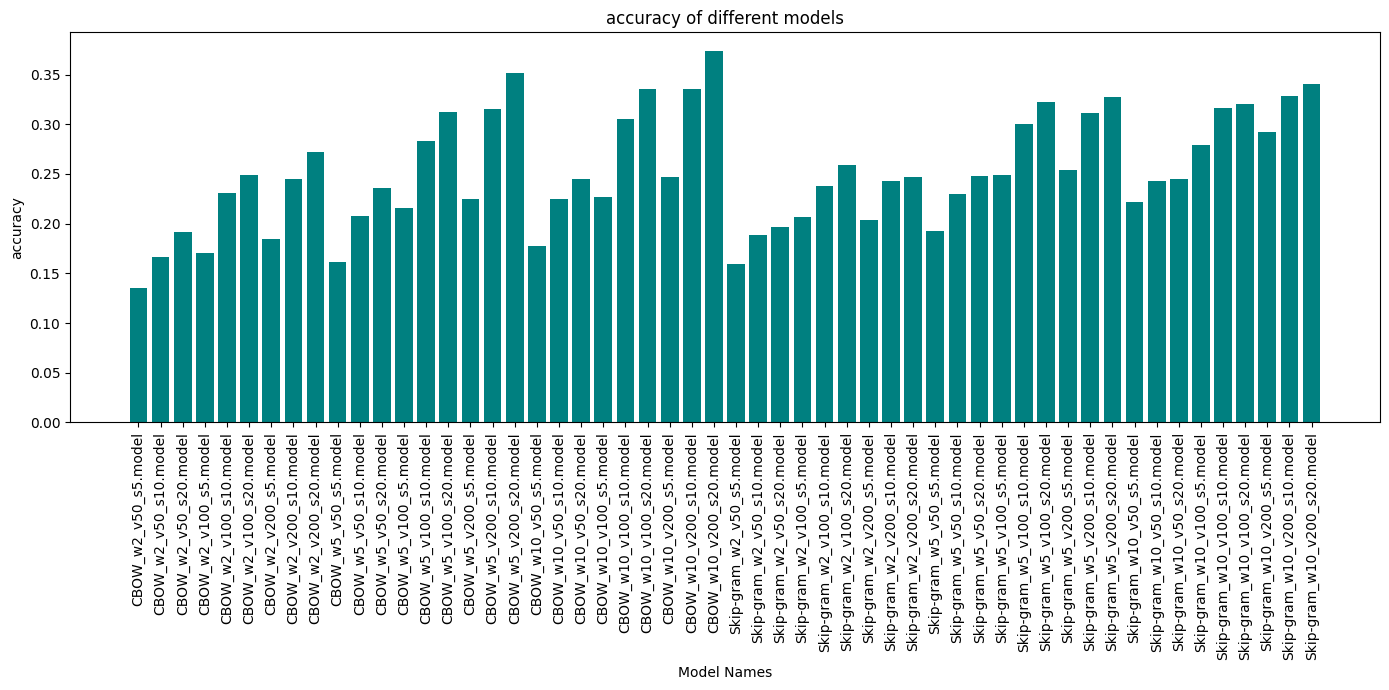

In [4]:
# Get Highest Accuracy
def get_best_model_by_accuracy(results):
    best_model = max(results.items(), key=lambda item: item[1]['accuracy'])
    return best_model

best_accuracy_model_name, best_accuracy_metrics = get_best_model_by_accuracy(results)
print(f"\033[1mBest Model by Accuracy: {best_accuracy_model_name} with accuracy {best_accuracy_metrics['accuracy']}\033[0m\n]n")
plot_metric(results, 'accuracy')

In [5]:
# Get top 3 best accuracy models
top3_accuracy = sorted(results.items(), key=lambda item: item[1]['accuracy'], reverse=True)[:3]
print("Top 3 best accuracy\n")
for model in top3_accuracy:
  hp = getHyperparameters(model[0])
  print(f"Hyperparameters\nModel type: {hp[0]}\nWindow Size: {hp[1]}\nVector Size: {hp[2]}\nEpochs: {hp[3]}\n\nAccuracy: {model[1]['accuracy']}\n\n")

Top 3 best accuracy

Hyperparameters
Model type: CBOW
Window Size: 10
Vector Size: 200
Epochs: 20

Accuracy: 0.3737569349942427


Hyperparameters
Model type: CBOW
Window Size: 5
Vector Size: 200
Epochs: 20

Accuracy: 0.35114623678425627


Hyperparameters
Model type: Skip-gram
Window Size: 10
Vector Size: 200
Epochs: 20

Accuracy: 0.3399979064168324




From the cell above, we can see that hyperparameters:

**Model type:** CBOW

**Window Size:** varies

**Vector Size**: 200

**Epochs**: 5

gave overall **best accuracy results**

## Distance

Best Model by Mean Distance: Skip-gram_w5_v50_s5.model with mean distance 0.27227452089721477




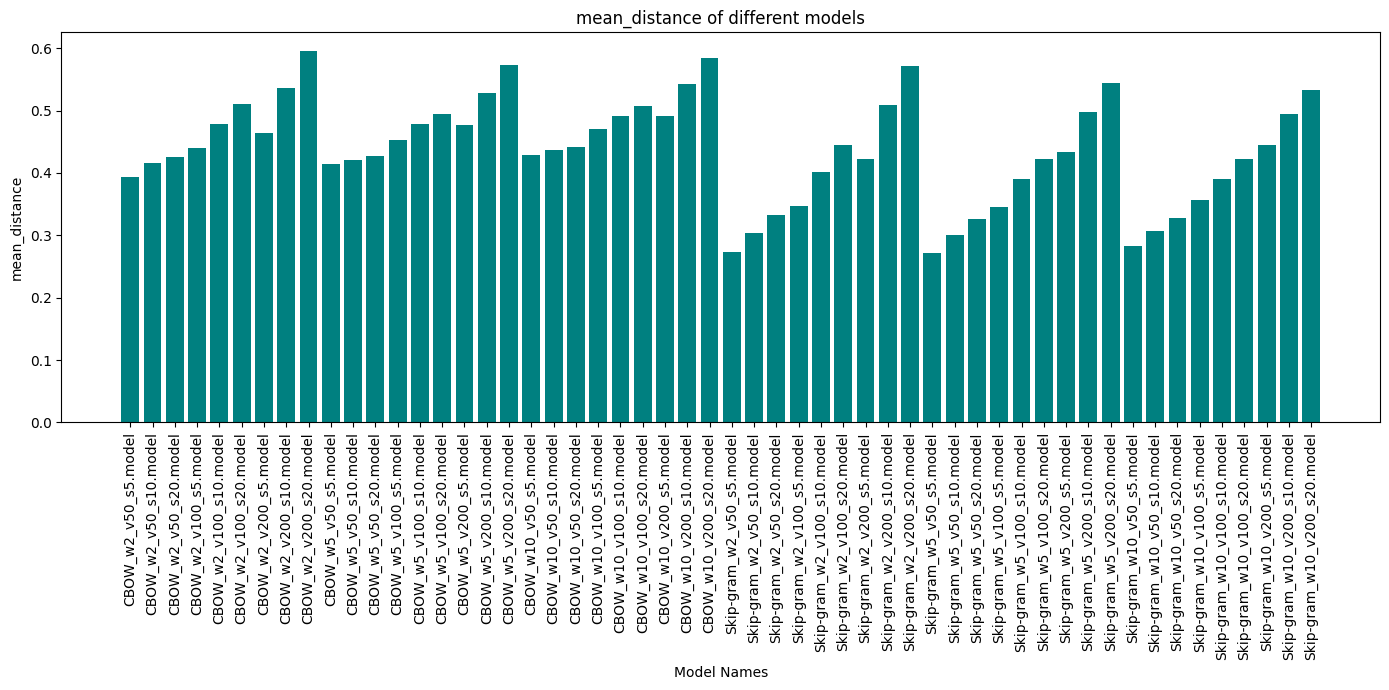

In [6]:
# Get Lowest Mean Distance
def get_best_model_by_distance(results):
    best_model = min(results.items(), key=lambda item: item[1]['mean_distance'])
    return best_model

best_distance_model_name, best_distance_metrics = get_best_model_by_distance(results)
print(f"\033[1mBest Model by Mean Distance: {best_distance_model_name} with mean distance {best_distance_metrics['mean_distance']}\033[0m\n\n")
plot_metric(results, 'mean_distance')

In [7]:
# Get top 3 best distance models
top3_distance = sorted(results.items(), key=lambda item: item[1]['mean_distance'])[:3]
print("Top 3 best mean distance\n")
for model in top3_distance:
  hp = getHyperparameters(model[0])
  print(f"Hyperparameters\nModel type: {hp[0]}\nWindow Size: {hp[1]}\nVector Size: {hp[2]}\nEpochs: {hp[3]}\n\nDistance: {model[1]['mean_distance']}\n\n")

Top 3 best mean distance

Hyperparameters
Model type: Skip-gram
Window Size: 5
Vector Size: 50
Epochs: 5

Distance: 0.27227452089721477


Hyperparameters
Model type: Skip-gram
Window Size: 2
Vector Size: 50
Epochs: 5

Distance: 0.27334057588943694


Hyperparameters
Model type: Skip-gram
Window Size: 10
Vector Size: 50
Epochs: 5

Distance: 0.28221804935719197




From the cell above, we can see that hyperparameters:

**Model type:** Skip-gram

**Window Size:** varies

**Vector Size**: 50

**Epochs**: 5

gave overall **best distance results**

## Similarity

Best Model by Similarity: Skip-gram_w5_v50_s5.model with mean similarity 0.7277254786102166




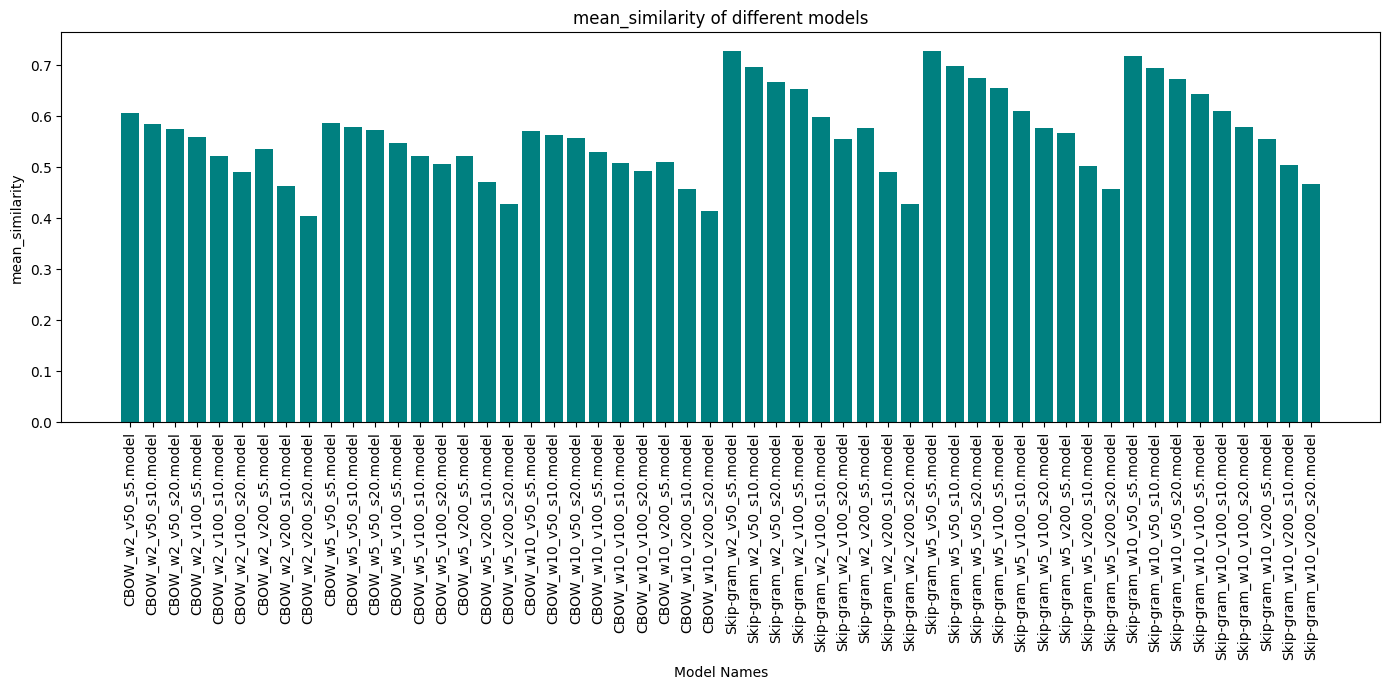

In [8]:
# Get Highest Similarity
def get_best_model_by_similarity(results):
    best_model = max(results.items(), key=lambda item: item[1]['mean_similarity'])
    return best_model

best_similarity_model_name, best_similarity_metrics = get_best_model_by_similarity(results)
print(f"\033[1mBest Model by Similarity: {best_similarity_model_name} with mean similarity {best_similarity_metrics['mean_similarity']}\033[0m\n\n")
plot_metric(results, 'mean_similarity')

In [9]:
# Get top 3 best similarity models
top3_similarity = sorted(results.items(), key=lambda item: item[1]['mean_similarity'], reverse=True)[:3]
print("Top 3 best mean similarity\n")
for model in top3_similarity:
  hp = getHyperparameters(model[0])
  print(f"Hyperparameters\nModel type: {hp[0]}\nWindow Size: {hp[1]}\nVector Size: {hp[2]}\nEpochs: {hp[3]}\n\nSimilarity: {model[1]['mean_similarity']}\n\n")

Top 3 best mean similarity

Hyperparameters
Model type: Skip-gram
Window Size: 5
Vector Size: 50
Epochs: 5

Similarity: 0.7277254786102166


Hyperparameters
Model type: Skip-gram
Window Size: 2
Vector Size: 50
Epochs: 5

Similarity: 0.7266594270869835


Hyperparameters
Model type: Skip-gram
Window Size: 10
Vector Size: 50
Epochs: 5

Similarity: 0.7177819516415206




From the cell above, we can see that hyperparameters:

**Model type:** Skip-gram

**Window Size:** varies

**Vector Size**: 50

**Epochs**: 5

gave overall **best similarity results**

### **This is obviously equals to Distance analysis since the highest the similarity the lowest the distance.**

## Best of each

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bests_metrics(results, best_accuracy_model_name, best_distance_model_name, best_similarity_model_name):
  metrics = ['mean_distance', 'mean_similarity', 'accuracy']
  metric_labels = ['Mean Distance', 'Mean Similarity', 'Accuracy']

  # Define Colors for Metrics
  metric_colors = {'mean_distance': 'blue', 'mean_similarity': 'green', 'accuracy': 'red'}

  selected_models = {
    'Best Accuracy': results[best_accuracy_model_name],
    'Best Distance': results[best_distance_model_name],
    'Best Similarity': results[best_similarity_model_name]
  }

  # Extract Model Names
  model_names = list(selected_models.keys())

  # Extract Metric Values
  data = {metric: [selected_models[model][metric] for model in model_names] for metric in metrics}


  # Set up the figure and axes
  fig, ax = plt.subplots(figsize=(12, 7))

  # Define Bar Width and Positions
  bar_width = 0.2
  indices = np.arange(len(metrics))  # [0, 1, 2] for the three metrics

  # Plot Each Metric
  for i, metric in enumerate(metrics):
      metric_values = data[metric]
      positions = indices + i * bar_width
      ax.bar(positions, metric_values, bar_width, label=metric_labels[i], color=metric_colors[metric], edgecolor='black')

      # Annotate Bars with Values
      for pos, value in zip(positions, metric_values):
          ax.text(pos, value + 0.001, f"{value:.4f}", ha='center', va='bottom', fontsize=8)

  # Customize X-axis
  ax.set_xlabel('Best Models', fontsize=12)
  ax.set_ylabel('Metric Values', fontsize=12)
  ax.set_title('Metrics of Best Models', fontsize=14)
  ax.set_xticks(indices + bar_width)
  ax.set_xticklabels(model_names, rotation=45, ha='right')

  # Add Legend
  ax.legend(title='Metrics')

  # Optimize Layout
  plt.tight_layout()

  # Display the Plot
  plt.show()


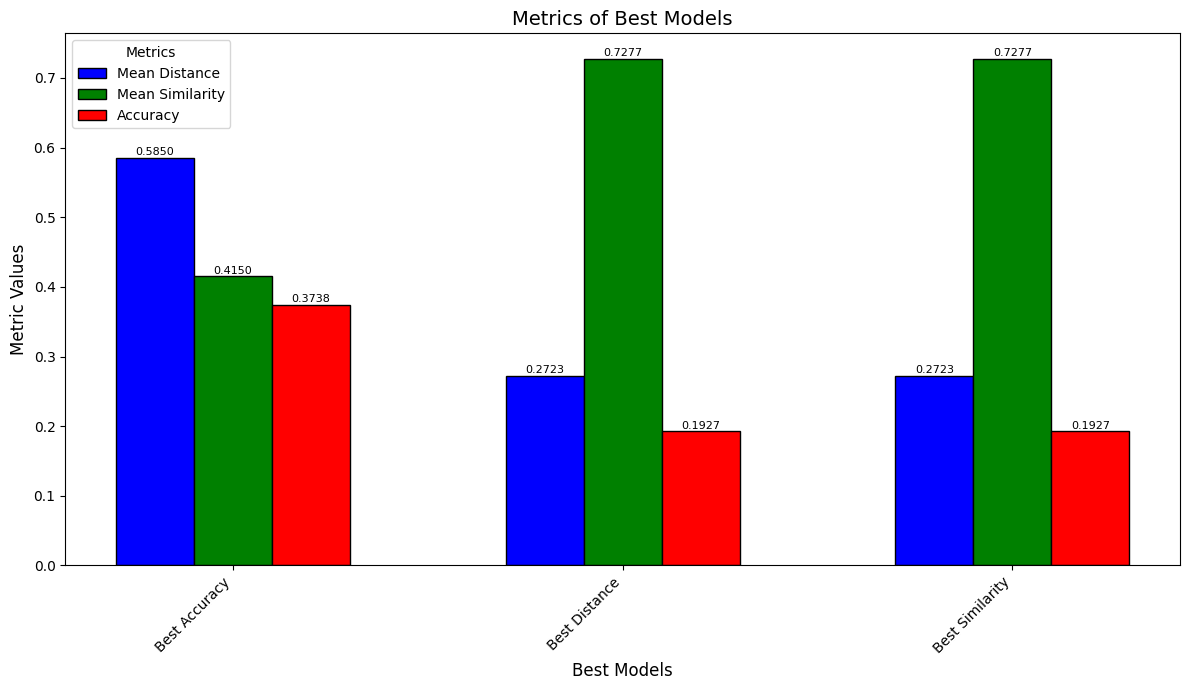

In [11]:
# Plot all metrics from models with best accuracy, similarity and distance (they were already calculated and printed on the cells above, here we're just showing them)
plot_bests_metrics(results, best_accuracy_model_name, best_distance_model_name, best_similarity_model_name)

# Conclusion

The best model (lowest distance, which implies highest similarity) was model:

Hyperparameters

**Model type:** Skip-gram

**Window Size:** 5

**Vector Size:** 50

**Epochs:** 5

### **Similarity: 0.7277254786102166**

### **Distance: 0.27227452089721477**